<a href="https://colab.research.google.com/github/gosaitos/Computer_vision/blob/main/Descriptors_classification_and_obj_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

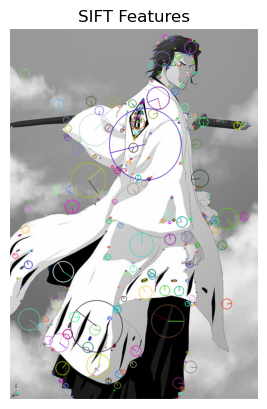

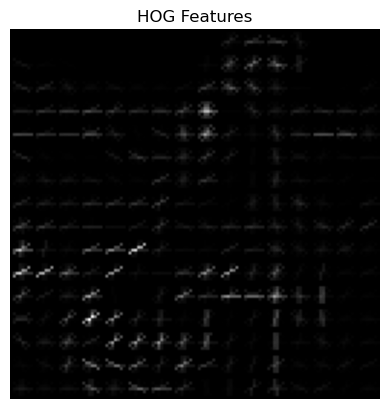

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib
from skimage.feature import hog

image = cv2.imread("aizen.jpg" )
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
keypoints, _ = sift.detectAndCompute(gray, None)
sift_img = cv2.drawKeypoints(gray, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(sift_img, cmap='gray')
plt.title("SIFT Features")
plt.axis("off")
plt.show()

resized_img = cv2.resize(gray, (128, 128))
hog_features, hog_img = hog(resized_img,
                             orientations=9,
                             pixels_per_cell=(8, 8),
                             cells_per_block=(2, 2),
                             visualize=True,
                             block_norm='L2-Hys')
plt.imshow(hog_img, cmap='gray')
plt.title("HOG Features")
plt.axis("off")
plt.show()

Predicted Label: Cat


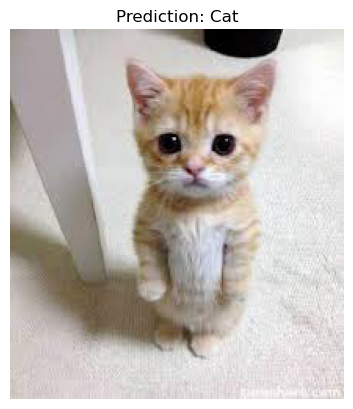

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def extract_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(gray, (128, 128))
    hog_features, _ = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    return hog_features

def extract_sift_features(image, feature_size=128):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
        return np.zeros(feature_size)
    descriptors = descriptors.flatten()
    if descriptors.shape[0] < feature_size:
        descriptors = np.pad(descriptors, (0, feature_size - descriptors.shape[0]), 'constant')
    else:
        descriptors = descriptors[:feature_size]
    return descriptors

def extract_features(image):
    hog_feat = extract_hog_features(image)
    sift_feat = extract_sift_features(image)
    return np.hstack((hog_feat, sift_feat))

def load_dataset(cats_folder, dogs_folder):
    features, labels = [], []
    for folder, label in [(cats_folder, 0), (dogs_folder, 1)]:
        for file_name in os.listdir(folder):
            image_path = os.path.join(folder, file_name)
            image = cv2.imread(image_path)
            if image is None:
                continue
            features.append(extract_features(image))
            labels.append(label)
    return np.array(features), np.array(labels)

def classify_image(model, scaler, pca, image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read image.")
        return
    features = extract_features(image)
    features = scaler.transform([features])
    features = pca.transform(features)
    prediction = model.predict(features)[0]
    label_text = "Cat" if prediction == 0 else "Dog"
    print(f"Predicted Label: {label_text}")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {label_text}")
    plt.axis("off")
    plt.show()

cats_folder = "cats_set"
dogs_folder = "dogs_set"
X, y = load_dataset(cats_folder, dogs_folder)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=100)  # Adjust components as needed
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(X_train, y_train)

image_path = "poonai.jpg"   # Change this to your test image path
classify_image(svm_classifier, scaler, pca, image_path)

In [ ]:
from sklearn.metrics import accuracy_score

# Predict on the test set
y_pred = svm_classifier.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 64.50%


Number of estimated clusters: 8


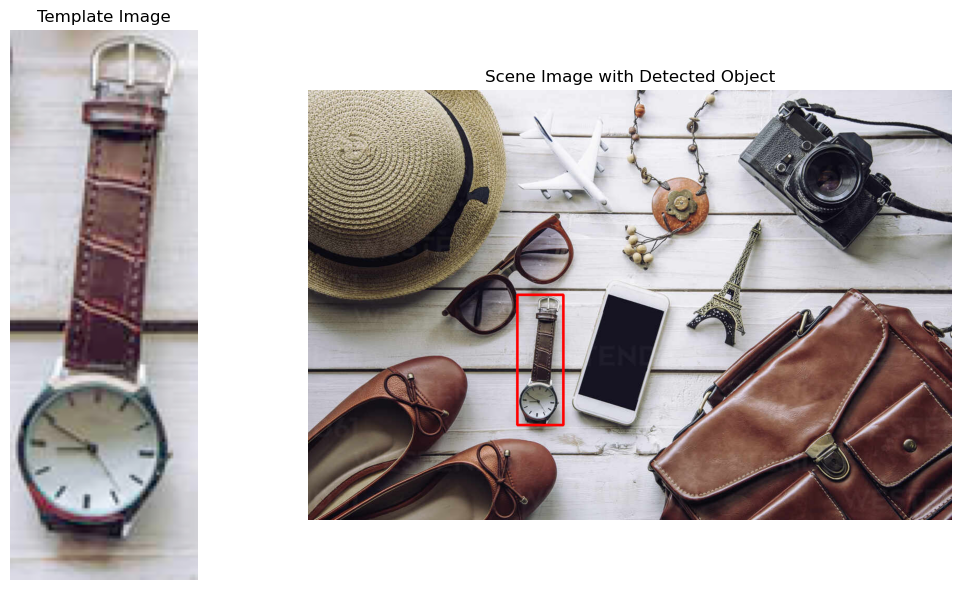

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth

MIN_MATCH_COUNT = 3

# Read images
img1 = cv2.imread("watch.jpg")
img2 = cv2.imread("scene.jpg")

# Convert img2 for drawing later
img_rgb = img2.copy()

# Initialize SIFT
alg = cv2.SIFT_create()  # Use xfeatures2d.SIFT_create() for older OpenCV versions

# Detect keypoints and descriptors
kp1, des1 = alg.detectAndCompute(img1, None)
kp2, des2 = alg.detectAndCompute(img2, None)

# Prepare data for clustering
x = np.array([kp2[0].pt])
for i in range(len(kp2)):
    x = np.append(x, [kp2[i].pt], axis=0)
x = x[1:len(x)]  # Remove duplicate of first point

# Estimate bandwidth and apply MeanShift clustering
bandwidth = estimate_bandwidth(x, quantile=0.1, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
ms.fit(x)

labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("Number of estimated clusters: %d" % n_clusters_)

# Group keypoints by cluster
s = [None] * n_clusters_
for i in range(n_clusters_):
    l = ms.labels_
    d, = np.where(l == i)
    s[i] = list(kp2[xx] for xx in d)

des2_ = des2

# Loop through clusters
for i in range(n_clusters_):
    kp2 = s[i]
    d, = np.where(labels == i)
    des2 = des2_[d, :]

    if len(kp2) < 2 or len(kp1) < 2:
        continue

    # FLANN matcher
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    des1 = np.float32(des1)
    des2 = np.float32(des2)

    matches = flann.knnMatch(des1, des2, 2)
    good = []

    for m, n in matches:
        if m.distance < 0.5 * n.distance:
            good.append(m)

    # Proceed if enough good matches
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 2)
        if M is None:
            print("No Homography")
            continue

        # Draw bounding box
        h, w = img1.shape[:2]
        corners = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
        transformedCorners = cv2.perspectiveTransform(corners, M)

        x = int(transformedCorners[0][0][0])
        y = int(transformedCorners[0][0][1])

        # Draw rectangle and polygon
        cv2.rectangle(img_rgb, (x, y), (x+w+20, y+h+50), (0, 0, 255), 3)
        img2 = cv2.polylines(img2, [np.int32(transformedCorners)], True, (0, 0, 255), 2, cv2.LINE_AA)


# Convert images for matplotlib
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)

# Plot using matplotlib
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('Template Image')
plt.axis('off')
plt.imshow(img1_rgb)

plt.subplot(122)
plt.title('Scene Image with Detected Object')
plt.axis('off')
plt.imshow(img_rgb)

plt.tight_layout()
plt.show()